## CVU Open and Reproducible Research Computing (Fall 2021)

### Assignment Notebook 1: Time Series Analysis

#### 1. Install the `nwis` library (if it's not installed already)

In [1]:
!pip install nwis

#### 2. Import the libraries required for the assignment

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nwis import Nwis

output_pkl_file = 'streamflow_data_'

#### 3a. Choose one of the following USGS stream gages to analyze

Uncomment __one__ of the following `site_id` variable declarations. Leave `my_start_date` and `my_end_date` unchanged. All of the sites below have at least 40 years of record. Only the Cache la Poudre has less than 50. 

In [3]:
# site_id = '13185000' # Boise River at Twin Springs
# site_id = '13139510' # Big Wood River at Hailey
# site_id = '13246000' # North Fork of the Payette near Banks
# site_id = '13042500' # Henry's Fork Near Island Park
site_id = '06752260' # Cache La Poudre River near Fort Collins (CO)
#site_id = '09085000' # Roaring Fork River at Glenwood Springs (CO)

my_start_date = '1970-10-01'
my_end_date = '2020-09-30'

#### 4. Get the Flow Data

In [4]:
nwis_data = Nwis()
ds = nwis_data.get_data(site=site_id, start_date=my_start_date, end_date=my_end_date, data_type='dv')
ds

<xarray.Dataset>
Dimensions:   (datetime: 16613)
Coordinates:
  * datetime  (datetime) datetime64[ns] 1975-04-08 1975-04-09 ... 2020-09-30
Data variables:
    00060     (datetime) float64 6.0 6.0 5.7 11.0 6.4 ... 8.19 8.38 9.76 8.23
Attributes:
    site_name:         CACHE LA POUDRE RIVER AT FORT COLLINS, CO
    site_code:         06752260
    site_latitude:     40.5880833
    site_longitude:    -105.0692222
    site_altitude:     4940
    site_coord_datum:  NAD83

#### 5. Plot the Data

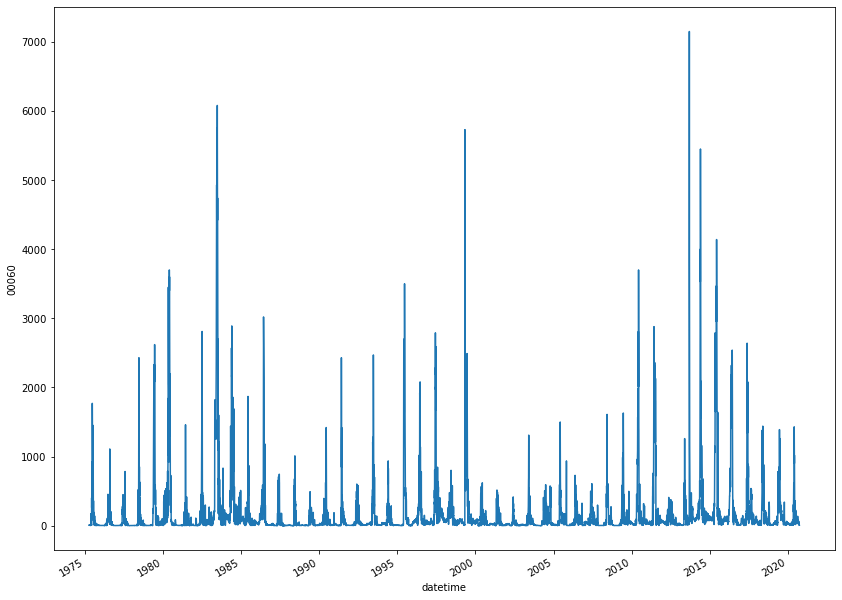

In [5]:
ds['00060'].plot(x='datetime', figsize=(14,10)) #I would be so interested to see this data through the 2021 flash flood

#### 6. Wrangle the Data into a `pandas` DataFrame object

Steps: 
* Get the dates and streamflow out of the object returned by our call to `Nwis.nwis()`
* Convert the streamflow in ft${}^3$/s to m${}^3$/s
* Create a water year vector so we can analyze data by water year
* Create a `pandas.DataFrame()` with the data

In [6]:
# Get the dates and convert them to a Pandas datetime object
dates = ds['datetime'].values
dates = pd.DatetimeIndex(dates) 

# Get the streamflow in ft^3/s as a numerical array and create one that is the same values but in m^3/s
Q_cfs = ds['00060'].values
Q_cms = Q_cfs / (3.2808**3)

# Create a water year vector by getting the year for every streamflow observation, checking the 
# associated month of that observation and then – if that month is October (10) or onward – add
# 1 to the water year
WY = ds['datetime.year'].values
WY[dates.month>=10] += 1

# Create a pandas DataFrame from these variables
df = pd.DataFrame()
df['Dates'] = dates
df['WaterYear'] = WY
df['Discharge_cfs'] = Q_cfs
df['Discharge_cms'] = Q_cms

# Rebuild the index to be able to use the pd.DataFrame.groupby() method
df.index = pd.to_datetime(df['Dates'],'%y-%m-%d')

# Save to a pickle file
# Question: What's going on with the file name? 
df.to_pickle(output_pkl_file+site_id+'.pkl')
df

,Dates,WaterYear,Discharge_cfs,Discharge_cms
Dates,,,,
1975-04-08,1975-04-08,1975,6.00,0.169907
1975-04-09,1975-04-09,1975,6.00,0.169907
1975-04-10,1975-04-10,1975,5.70,0.161412
1975-04-11,1975-04-11,1975,11.00,0.311497
1975-04-12,1975-04-12,1975,6.40,0.181234
...,...,...,...,...
2020-09-26,2020-09-26,2020,10.40,0.294506
2020-09-27,2020-09-27,2020,8.19,0.231923
2020-09-28,2020-09-28,2020,8.38,0.237304


#### 7. Compute the Seasonal Cycle and Plot

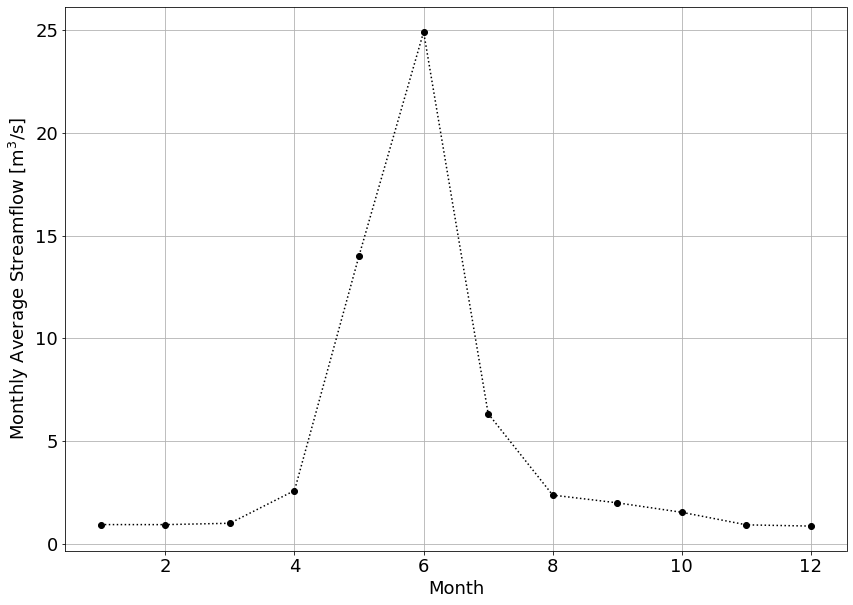

In [7]:
q_seasonal = df['Discharge_cms'].groupby(by=df.index.month).mean().values

plt.figure(figsize=(14,10))
plt.rcParams.update({'font.size': 18}) # Increase the font size
plt.plot((np.arange(q_seasonal.size)+1),q_seasonal,'ko:')
plt.xlabel('Month')
plt.ylabel('Monthly Average Streamflow [m${}^3$/s]')
plt.grid()
plt.show()

## Instructions
---

1. Download this notebook into the folder for your repository for this module by opening a terminal window, navigating to your repository folder and issuing the command `curl -OL https://raw.githubusercontent.com/LejoFlores/Open-And-Reproducible-Research-Computing/main/mod02/mod02_assignment.ipynb` 
2. Verify that the notebook runs to this point 
3. Go back and change the `site_id` variable to a gage of your choosing by commenting out the current gage selected and uncommenting the gage you would like to investigate. Then in the Jupyter Lab menu go to "Kernel > Restart Kernel and Clear All Outputs" and click "Restart" when prompted
4. Re-run the notebook to this point
5. Now group the streamflow data by `WaterYear` and get the maximum streamflow value for each Water Year. You will need to use the `.groupby()` followed by the `.max()` methods. This should be very similar to the commands used to find the seasonal cycle above, but be sure to make sure to group by Water Year! Store the output of that operation in a variable called `Q_ams`. Print the output of `Q_ams` to see which years were associated with the lowest 5 and highest 5 annual maximum streamflows. __Note:__ See this [DataFrame.groupby()](https://www.geeksforgeeks.org/pandas-groupby/) and [DataFrame.max()](https://www.geeksforgeeks.org/python-pandas-dataframe-max/) documentation for help. 
6. Now sort the annual maximum series in ___descending order___ using the `.sort_values()` method. Use the `.values` to save these values to a numpy array. __Note:__ See this [DataFrame.sort_values()](https://www.geeksforgeeks.org/python-pandas-dataframe-sort_values-set-1/) and [DataFrame.values](https://www.geeksforgeeks.org/python-pandas-dataframe-values/) documentation for help. 
7. Compute the Weibull plotting position value for each streamflow value. The Weibull series is calculated using the formula:

    $$
    p_i = \frac{r_i}{n+1},
    $$

    where $r_i$ is the rank of the $i$th observation, $n$ is the number of annual maximum observations, and $p_i$ is the exceedance probability. Use the numpy command `np.arange()` method and the `.size` attribute on your annual maximum series array to create an array of ranks associated with each annual maximum value.
8. Create a presentation quality plot showing the annual maximum streamflows on the x-axis and the exceedance probability on the y axis. __Note:__ See this [numpy.arange()](https://numpy.org/doc/stable/reference/generated/numpy.arange.html) and [numpy.size()](https://numpy.org/doc/stable/reference/generated/numpy.broadcast.size.html) documentation for help. 
9. The $T$-year recurrence interval is associated with an exceedance probability of $p$ which is calculated using:

    $$ 
    p = \frac{1}{T} 
    $$

    Calculate the values of the 20- and 50- year recurrence interval events directly from the Weibull plotting position values by using the numpy `np.interp()` function, which does a very basic interpolation (there are more sophisticated ones, but this is sufficient for now). __Note:__ See this [numpy.interp()](https://www.geeksforgeeks.org/numpy-interp-function-python/) documentation for help.  

In [8]:
Q_ams = df['Discharge_cms'].groupby(by=WY).max() #groups discharge by water year and reports maximum
Q_ams

1975     50.122647
1976     31.432846
1977     22.201218
1978     68.812447
1979     74.192845
1980    104.776155
1981     41.344104
1982     79.573242
1983    172.172708
1984     81.838672
1985     52.954435
1986     85.519996
1987     21.096820
1988     28.601058
1989     13.932397
1990     40.211389
1991     68.812447
1992     17.047364
1993     69.945163
1994     26.533853
1995     99.112579
1996     58.901190
1997     79.006884
1998     22.682622
1999    162.261450
2000     17.557085
2001     14.612026
2002     11.780238
2003     37.096422
2004     16.792503
2005     42.476819
2006     26.533853
2007     17.217271
2008     45.591786
2009     46.158144
2010    104.776155
2011     81.555493
2012     11.582013
2013    202.472839
2014    154.332444
2015    117.236022
2016     71.927414
2017     74.759202
2018     40.777747
2019     39.361853
2020     40.494568
Name: Discharge_cms, dtype: float64

In [9]:
Q_ams_sort = Q_ams.sort_values(ascending=False) #sorts maximum Q in WY in descending order
Q_ams_sort

2013    202.472839
1983    172.172708
1999    162.261450
2014    154.332444
2015    117.236022
1980    104.776155
2010    104.776155
1995     99.112579
1986     85.519996
1984     81.838672
2011     81.555493
1982     79.573242
1997     79.006884
2017     74.759202
1979     74.192845
2016     71.927414
1993     69.945163
1991     68.812447
1978     68.812447
1996     58.901190
1985     52.954435
1975     50.122647
2009     46.158144
2008     45.591786
2005     42.476819
1981     41.344104
2018     40.777747
2020     40.494568
1990     40.211389
2019     39.361853
2003     37.096422
1976     31.432846
1988     28.601058
2006     26.533853
1994     26.533853
1998     22.682622
1977     22.201218
1987     21.096820
2000     17.557085
2007     17.217271
1992     17.047364
2004     16.792503
2001     14.612026
1989     13.932397
2002     11.780238
2012     11.582013
Name: Discharge_cms, dtype: float64

In [10]:
Q_ams_sort = Q_ams.sort_values(ascending=False).values #creates array out of sorted max Q by WY data
Q_ams_sort

array([202.47283925, 172.17270806, 162.2614502 , 154.33244391,
       117.23602161, 104.77615458, 104.77615458,  99.11257865,
        85.51999644,  81.83867209,  81.55549329,  79.57324172,
        79.00688413,  74.75920219,  74.19284459,  71.92741422,
        69.94516265,  68.81244747,  68.81244747,  58.9011896 ,
        52.95443488,  50.12264692,  46.15814377,  45.59178618,
        42.47681942,  41.34410424,  40.77774665,  40.49456785,
        40.21138905,  39.36185267,  37.0964223 ,  31.43284637,
        28.60105841,  26.5338532 ,  26.5338532 ,  22.68262157,
        22.20121762,  21.09682031,  17.55708536,  17.21727081,
        17.04736353,  16.79250261,  14.61202588,  13.93239677,
        11.78023792,  11.58201276])

In [11]:
Q_ams_sort.size #reports size of array, needed in next step
rank1 = np.arange(46)+1 #creates array from 1 to 46
rank1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46])

In [12]:
p_ams = np.divide(rank1, 47) # p = r/(n+1)
p_ams

array([0.0212766 , 0.04255319, 0.06382979, 0.08510638, 0.10638298,
       0.12765957, 0.14893617, 0.17021277, 0.19148936, 0.21276596,
       0.23404255, 0.25531915, 0.27659574, 0.29787234, 0.31914894,
       0.34042553, 0.36170213, 0.38297872, 0.40425532, 0.42553191,
       0.44680851, 0.46808511, 0.4893617 , 0.5106383 , 0.53191489,
       0.55319149, 0.57446809, 0.59574468, 0.61702128, 0.63829787,
       0.65957447, 0.68085106, 0.70212766, 0.72340426, 0.74468085,
       0.76595745, 0.78723404, 0.80851064, 0.82978723, 0.85106383,
       0.87234043, 0.89361702, 0.91489362, 0.93617021, 0.95744681,
       0.9787234 ])

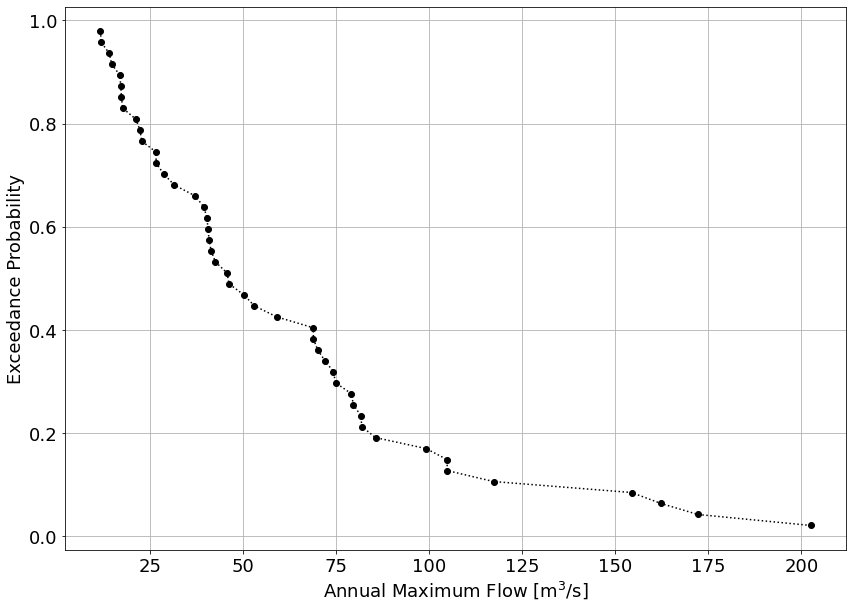

In [13]:
plt.figure(figsize=(14,10))
plt.rcParams.update({'font.size':18})
plt.plot(Q_ams_sort,p_ams,'ko:')
plt.ylabel('Exceedance Probability')
plt.xlabel('Annual Maximum Flow [m${}^3$/s]')
plt.grid()
plt.show()

In [14]:
P20 = 1/20 #using the equation p=1/T
P50 = 1/50
Q20 = np.interp(P20, p_ams, Q_ams_sort) #if P20 is the x-coord at which to evaluate interpolated values, p_ams is our x-array, while Q_ams_sort is our y-array
Q20
Q50 = np.interp(P50, p_ams, Q_ams_sort)

In [15]:
print('The 20-year flood event has a magnitude of {:.3f} m^3/s'.format(Q20))
print('The 50-year flood event has a magnitude of {:.3f} m^3/s'.format(Q50)) 

The 20-year flood event has a magnitude of 168.704 m^3/s
The 50-year flood event has a magnitude of 202.473 m^3/s
